Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Datensatz Shape: torch.Size([100, 400])
CSV-Datei gespeichert als: /content/drive/MyDrive/Project: Diffusion-TS/Diffusion-TS/Data/toy_dataset.csv


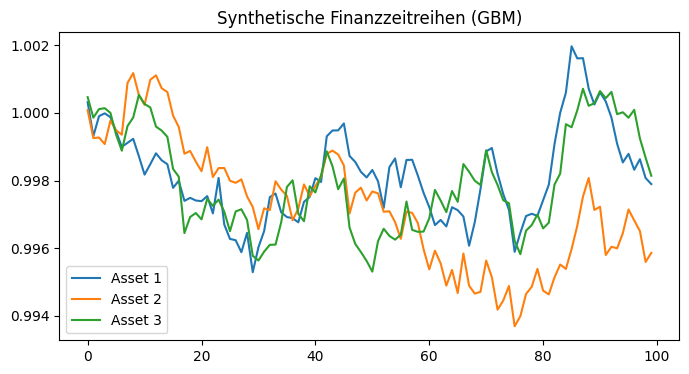

In [5]:
# Imports
from google.colab import drive
# Mount Google Drive to access files
drive.mount('/content/drive')
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt

def generate_financial_dataset(n_features=3, n_samples=100, seed=42,
                               mu=0.0005, sigma=0.01, corr_strength=0.5):
    """
    Erzeugt synthetische Finanzzeitreihen basierend auf geometrischer Brownscher Bewegung (GBM).
    Jede Feature-Spalte entspricht einer "Asset-Preisreihe".

    Args:
        n_features (int): Anzahl der Assets (Features).
        n_samples (int): Länge der Zeitreihe.
        seed (int): Zufalls-Seed für Reproduzierbarkeit.
        mu (float): Erwartete tägliche Rendite (Drift).
        sigma (float): Volatilität der Renditen.
        corr_strength (float): Korrelation zwischen Features (0 = unkorreliert, 1 = identisch).

    Returns:
        torch.Tensor: Shape (n_samples, n_features) – simulierte Preiszeitreihen
    """
    np.random.seed(seed)

    # Kovarianzmatrix für Korrelationen zwischen Assets
    corr_matrix = (1 - corr_strength) * np.eye(n_features) + corr_strength * np.ones((n_features, n_features))
    chol = np.linalg.cholesky(corr_matrix)  # Cholesky-Zerlegung für korrelierte Normalvariablen

    # Simuliere Renditen
    dt = 1/252  # ca. täglicher Schritt (252 Handelstage)
    returns = []
    for t in range(n_samples):
        z = np.random.normal(size=n_features)
        correlated = chol @ z
        r = mu*dt + sigma*np.sqrt(dt)*correlated
        returns.append(r)
    returns = np.stack(returns)  # (n_samples, n_features)

    # Preise aus Renditen aufbauen (log-normal)
    prices = np.exp(np.cumsum(returns, axis=0))

    return torch.tensor(prices, dtype=torch.float32)


# Beispiel: Datensatz erzeugen
n_features = 400
n_samples = 100
toy_data = generate_financial_dataset(n_features=n_features, n_samples=n_samples)

print("Datensatz Shape:", toy_data.shape)

# In Pandas DataFrame umwandeln
df = pd.DataFrame(toy_data.numpy(), columns=[f"Asset_{i+1}" for i in range(n_features)])

# CSV speichern
csv_filename = "/content/drive/MyDrive/Project: Diffusion-TS/Diffusion-TS/Data/toy_dataset.csv"
df.to_csv(csv_filename, index=False)

print(f"CSV-Datei gespeichert als: {csv_filename}")

# Plot der ersten paar Features
plt.figure(figsize=(8,4))
for i in range(min(3, n_features)):
    plt.plot(df[f"Asset_{i+1}"], label=f"Asset {i+1}")
plt.legend()
plt.title("Synthetische Finanzzeitreihen (GBM)")
plt.show()

# Größerer Test: viele Features

